# Mostrar todas las imagenes a usar

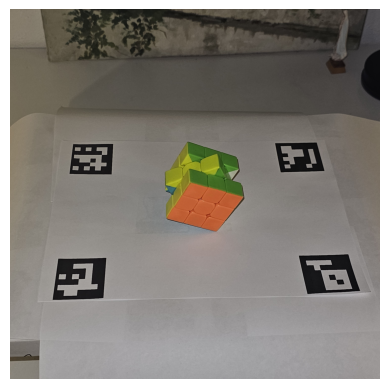

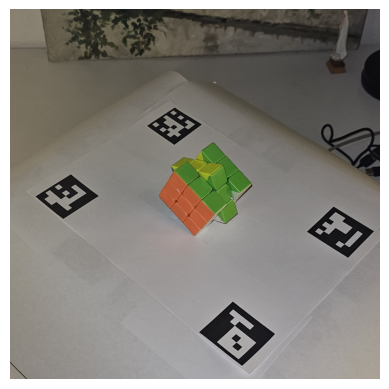

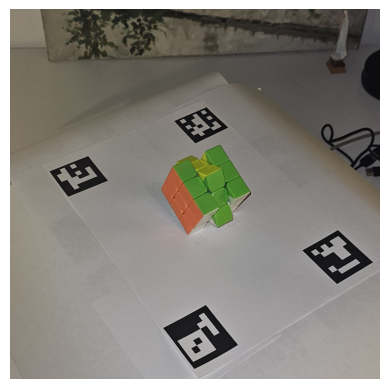

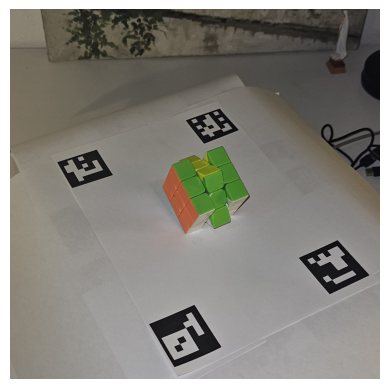

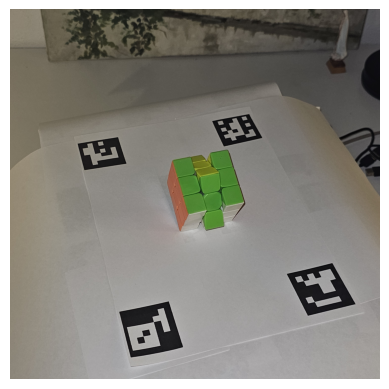

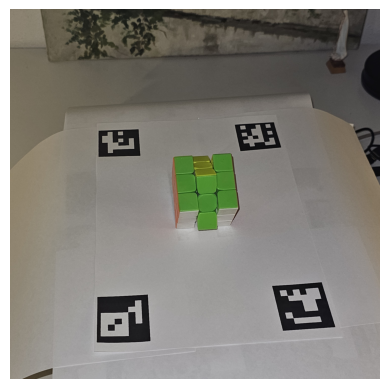

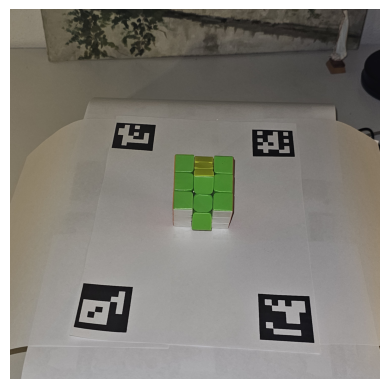

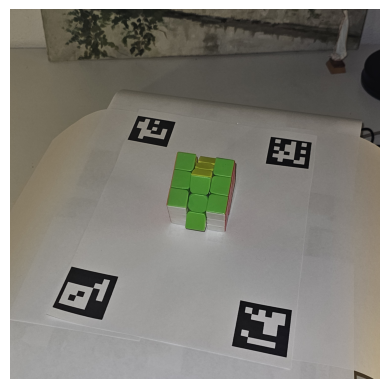

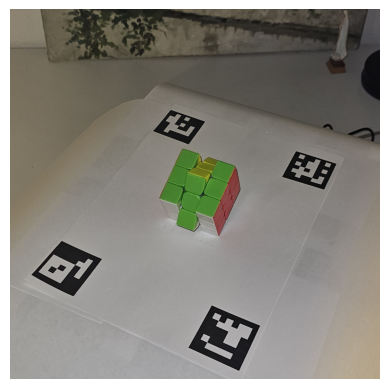

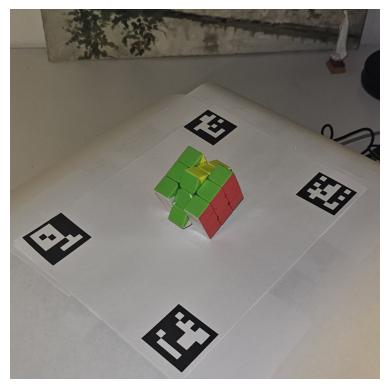

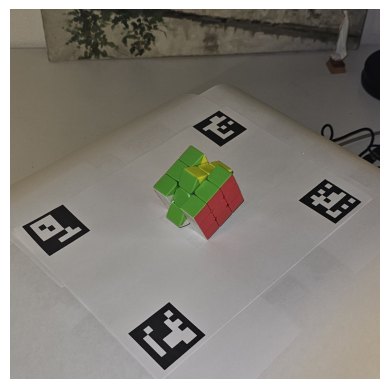

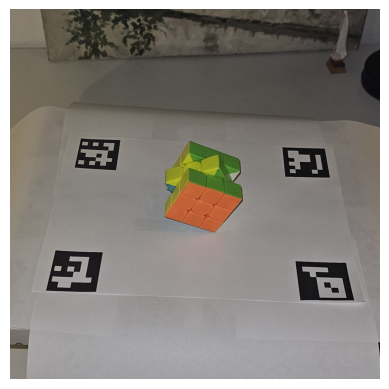

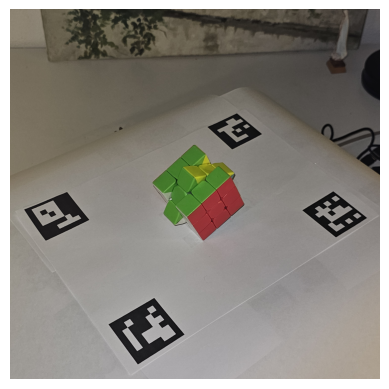

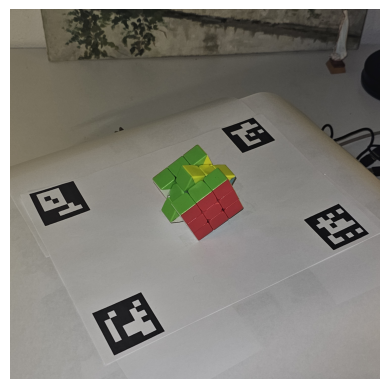

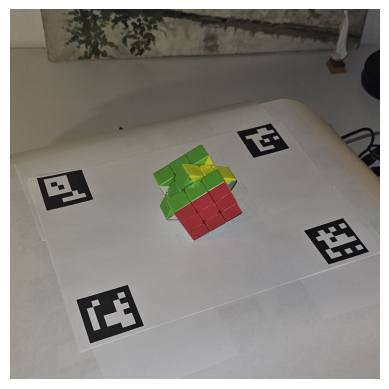

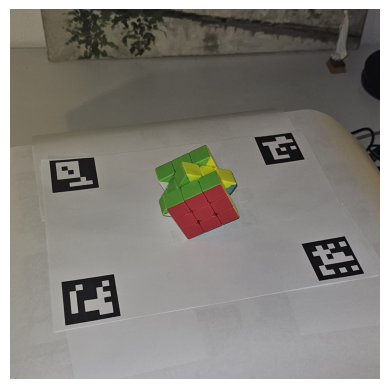

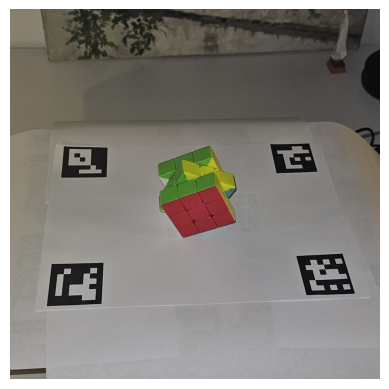

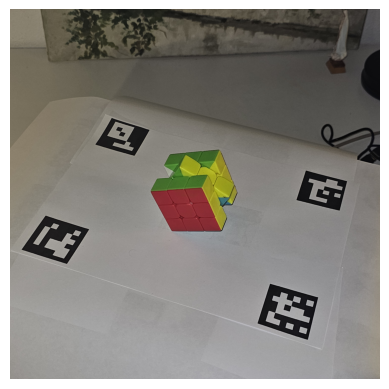

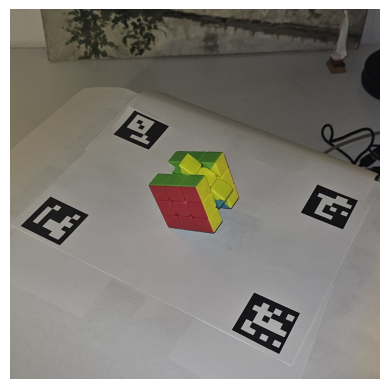

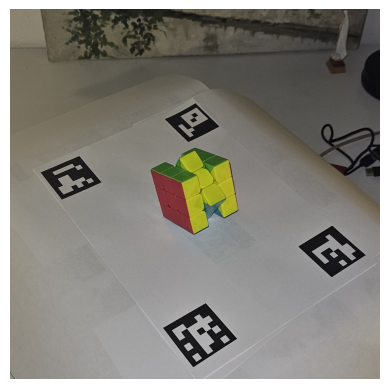

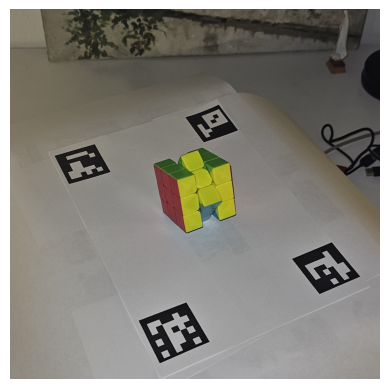

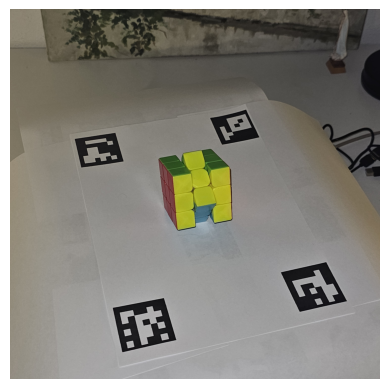

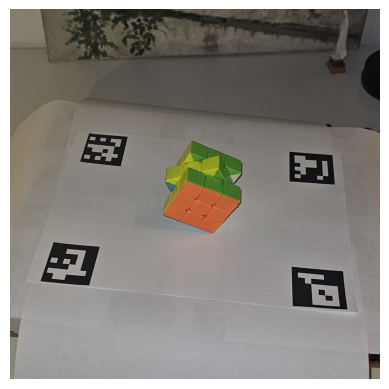

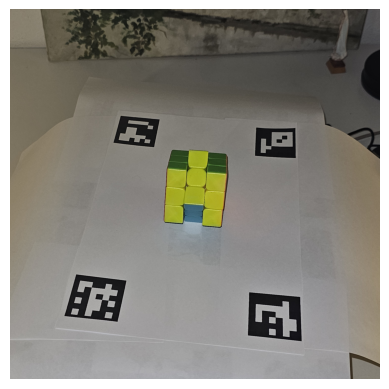

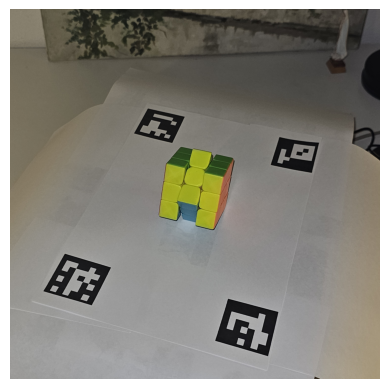

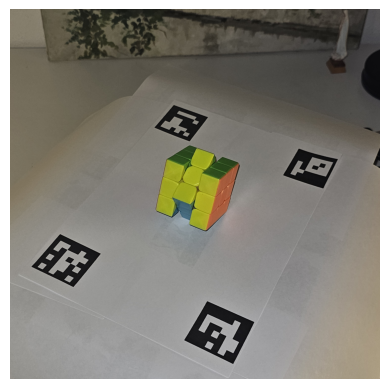

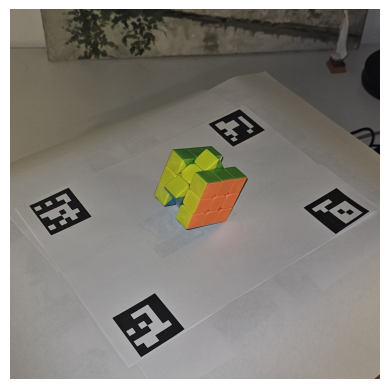

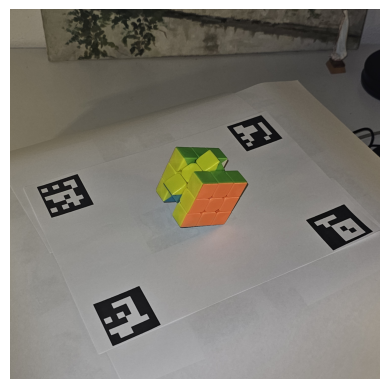

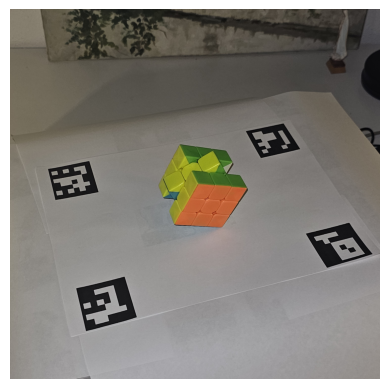

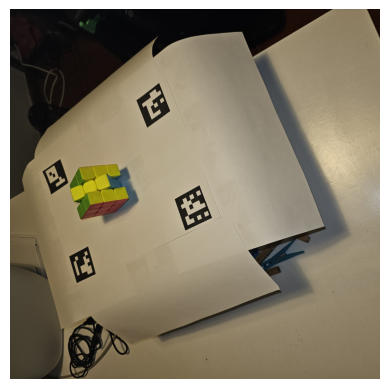

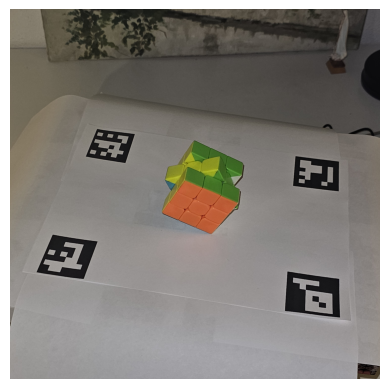

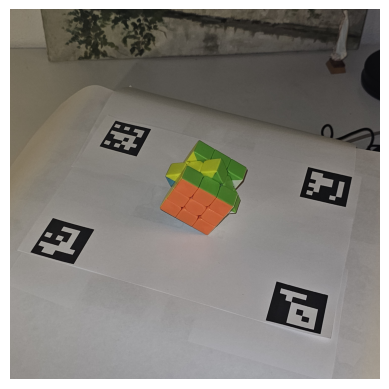

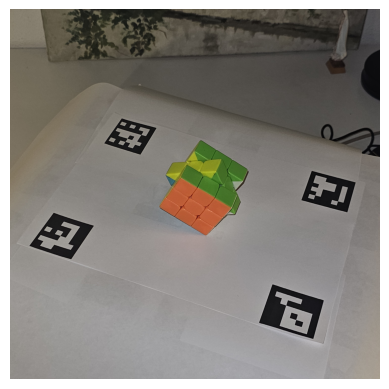

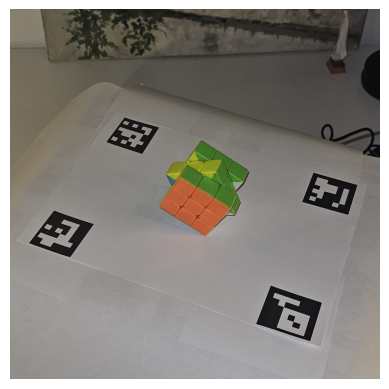

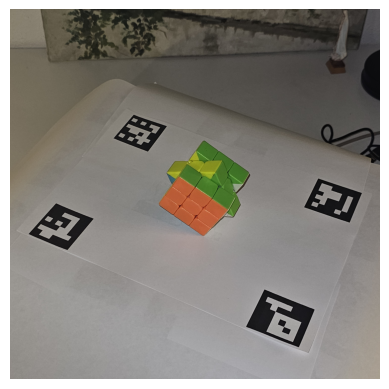

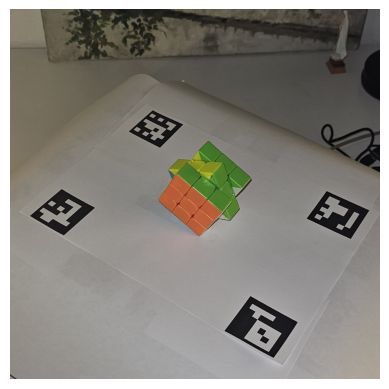

In [1]:
import matplotlib.pyplot as plt
import glob
import numpy as np  # Import numpy for array manipulation

# Specify the path to the images
images_paths = glob.glob('img/cube/*.jpg')

# Loop through all the image paths in the list
plt.figure()
for file_name in images_paths:
    img = plt.imread(file_name)      # Read the image file directly into an array
    img = np.flipud(img)             # Flip the image in the up/down direction
    plt.imshow(img)                  # Display the image
    plt.axis('off')                  # Remove the axes
    plt.show()                       # Show the image


# FUNCIÓN DE CALIBRADO

In [2]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt
def scanner_calibrate_camera(path='img/calibrate/showcase/angular.png',show_images=False):
    #---------------------------------PARAMETERS
    rows_count = 6
    columns_count = 9
    #---------------------------------
    # termination criteria
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((rows_count*columns_count,3), np.float32)
    objp[:,:2] = np.mgrid[0:columns_count,0:rows_count].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    #images = glob.glob('angular-1to1/*.jpg')
    images = glob.glob(path)
    for fname in images:
        print("Loading image: "+fname)
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (columns_count,rows_count), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            print(fname+": calibrate success")
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)
            # Draw and display the corners
            cv.drawChessboardCorners(img, (columns_count,rows_count), corners2, ret)
            if show_images:
                plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
                plt.axis("off")
                plt.show()
        else:
            print(fname+": chessboard not found")

    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

## showcase

Loading image: img/calibrate/showcase/angular.png
img/calibrate/showcase/angular.png: calibrate success


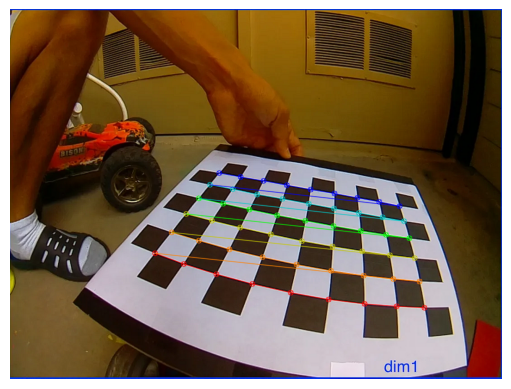

In [3]:
ret, mtx, dist, rvecs, tvecs = scanner_calibrate_camera(show_images=True)

# FUNCIÓN DE POSICIÓN

In [4]:
cv2 = cv
from cv2 import aruco
import pandas as pd
import matplotlib as mpl
from scipy.spatial.transform import Rotation
def get_camera_position(image, ret, mtx, dist, rvecs, tvecs):
    
    # 1. Lectura de la imagen
    photo = cv2.imread(image)
    
    # 2. Aplicación de ArUco
    gray = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
    parameters =  aruco.DetectorParameters()
    detector = aruco.ArucoDetector(aruco_dict, parameters)
    corners, ids, rejectedImgPoints = detector.detectMarkers(gray)
    photo_markers = aruco.drawDetectedMarkers(photo.copy(), corners, ids)
    
    for i in range(len(ids)):
        c = corners[i][0]
        plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))
        
    # 3. Lectura de ArUco
    def quad_area(data):
        l = data.shape[0]//2
        corners = data[["c1", "c2", "c3", "c4"]].values.reshape(l, 2,4)
        c1 = corners[:, :, 0]
        c2 = corners[:, :, 1]
        c3 = corners[:, :, 2]
        c4 = corners[:, :, 3]
        e1 = c2-c1
        e2 = c3-c2
        e3 = c4-c3
        e4 = c1-c4
        a = -.5 * (np.cross(-e1, e2, axis = 1) + np.cross(-e3, e4, axis = 1))
        return a

    corners2 = np.array([c[0] for c in corners])

    data = pd.DataFrame({"x": corners2[:,:,0].flatten(), "y": corners2[:,:,1].flatten()},
                       index = pd.MultiIndex.from_product( 
                               [ids.flatten(), ["c{0}".format(i )for i in np.arange(4)+1]], 
                           names = ["marker", ""] ))

    # print(data.index)  # This will show you all the index keys

    data = data.unstack().swaplevel(0, 1, axis = 1).stack()
    data["m1"] = data[["c1", "c2"]].mean(axis = 1)
    data["m2"] = data[["c2", "c3"]].mean(axis = 1)
    data["m3"] = data[["c3", "c4"]].mean(axis = 1)
    data["m4"] = data[["c4", "c1"]].mean(axis = 1)
    data["o"] = data[["m1", "m2", "m3", "m4"]].mean(axis = 1)
    
    # 4. Obtención de esquinas
    aruco1 = list(data.loc[(1, "c1")].values)
    aruco4 = list(data.loc[(4, "c2")].values)
    aruco12 = list(data.loc[(12, "c3")].values)
    aruco9 = list(data.loc[(9, "c4")].values)
    
    # 5. Estimación de la posición
    im = photo
    size = im.shape

    imageWidth = size[1]
    imageHeight = size[0]
    imageSize = [imageWidth, imageHeight]

    points_2D = np.array([
                                (aruco1),     (aruco4),
                                (aruco9),     (aruco12)     
                            ])


    points_3D = np.array([
                                (0., 202., 0),  (270., 202., 0),
                                (0., 0., 0),  (270., 0., 0)    
                            ])

    success, rvecs, tvecs = cv2.solvePnP(points_3D, points_2D, mtx, dist, flags=cv2.SOLVEPNP_ITERATIVE)

    np_rodrigues = np.asarray(rvecs[:,:],np.float64)
    rmat = cv2.Rodrigues(np_rodrigues)[0]
    camera_position = -np.matrix(rmat).T @ np.matrix(tvecs)

    #Test the solvePnP by projecting the 3D Points to camera
    projPoints = cv2.projectPoints(points_3D, rvecs, tvecs, mtx, dist)[0]

    for p in points_2D:
     cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,255,0), -1)

    for p in projPoints:
     cv2.circle(im, (int(p[0][0]), int(p[0][1])), 3, (255,0,0), -1)
    
    # 6. Estimación de la rotación

    r = Rotation.from_rotvec([rvecs[0][0],rvecs[1][0],rvecs[2][0]])
    rot = r.as_euler('xyz', degrees=True)

    # 7.Resultados finales
    
    tx = camera_position[0][0]
    ty = camera_position[1][0]
    tz = camera_position[2][0]

    rx = round(180-rot[0],5) 
    ry = round(rot[1],5) 
    rz = round(rot[2],5)
    
    position = [tx, ty, tz]
    rotation = [rx, ry, rz]
    
    return position, rotation , [
                                (aruco1),     (aruco4),
                                (aruco9),     (aruco12)     
                            ]

Loading image: img/calibrate/1.jpg
img/calibrate/1.jpg: calibrate success
Posición: [matrix([[89.3422422]]), matrix([[-56.7818657]]), matrix([[206.63170524]])]
Rotación: [35.55036, -14.23836, -17.47143]
[[182.0, 1424.0], [2064.0, 877.0], [565.0, 2684.0], [2837.0, 1893.0]]


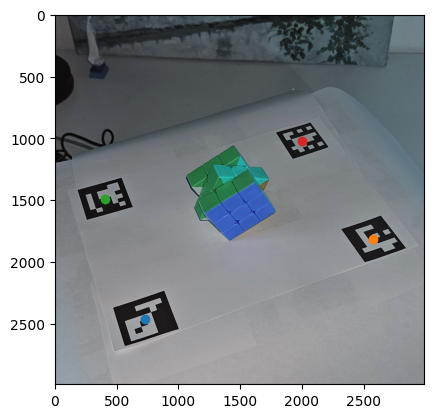

In [6]:
image_name = "img/cube/7.jpg"
calibration_image = "img/calibrate/1.jpg"
ret, mtx, dist, rvecs, tvecs = scanner_calibrate_camera(calibration_image)
position, rotation , arucos = get_camera_position(image_name, ret, mtx, dist, rvecs, tvecs)

plt.imshow(cv2.imread(image_name))
print("Posición:", position)
print("Rotación:", rotation)
print(arucos)

# Siluetas

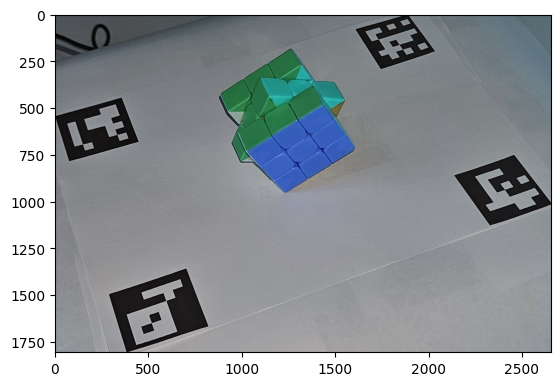

In [17]:
import cv2 as cv
import numpy as np

def trim_image_by_points(image, points_in_image,margin=[0,0,0,0] ):
    # Convert points to a numpy array if it isn't already
    points = np.array(points_in_image)

    # Calculate the minimum and maximum x and y coordinates
    min_x = np.min(points[:, 0])
    max_x = np.max(points[:, 0])
    min_y = np.min(points[:, 1])
    max_y = np.max(points[:, 1])

    # Trim the image using calculated coordinates
    trimmed_image = image[int(min_y+margin[0]):int(max_y+margin[1]), int(min_x+margin[2]):int(max_x+margin[3])]

    return trimmed_image

# Example usage:

image = cv2.imread(image_name)
plt.imshow(image)
points_in_image = [[182.0, 1424.0], [2064.0, 877.0], [565.0, 2684.0], [2837.0, 1893.0]]
result_image = trim_image_by_points(image,points_in_image,[0,0,0,0])
plt.imshow(result_image)

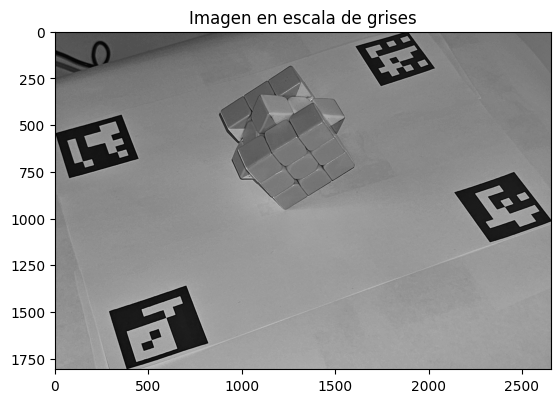

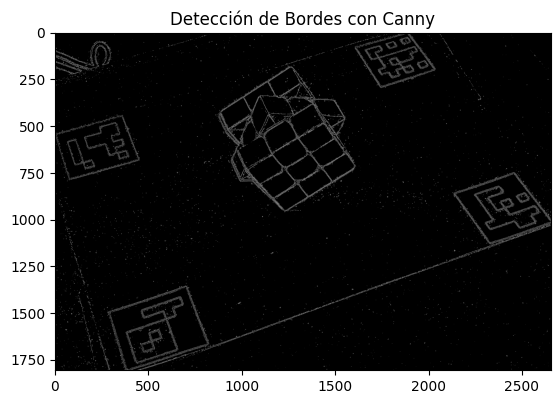

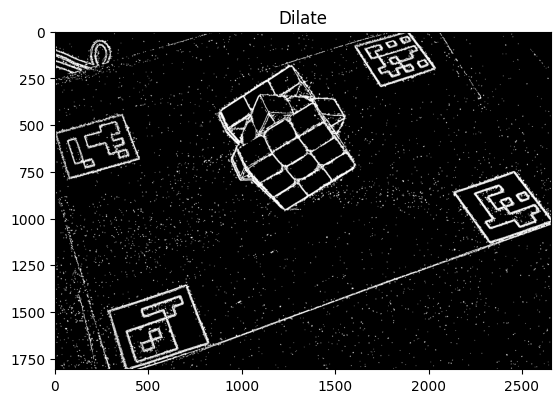

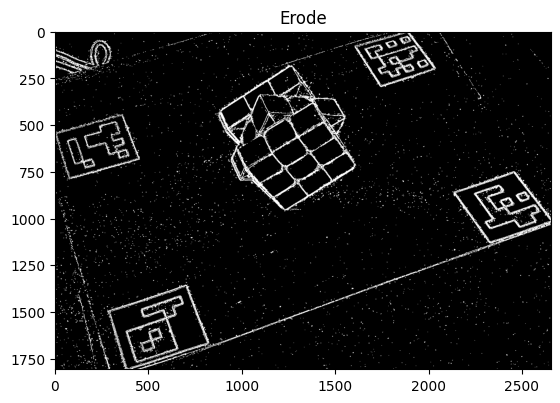

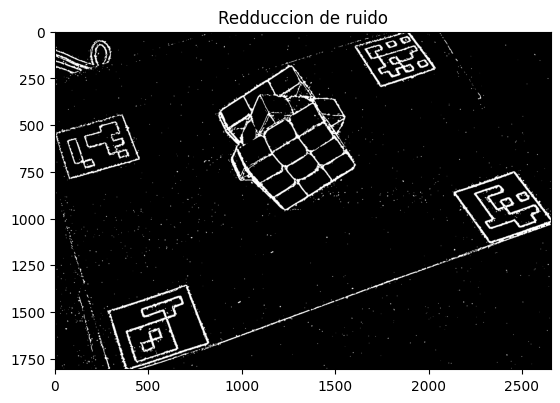

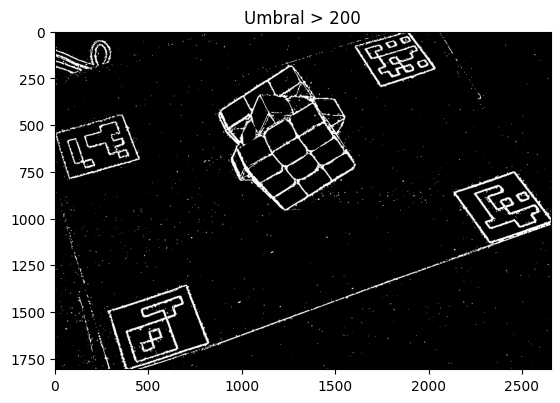

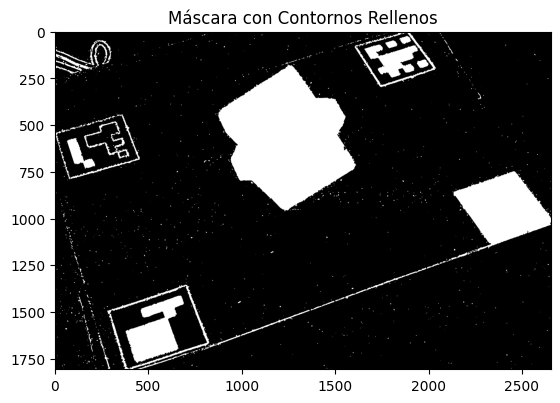

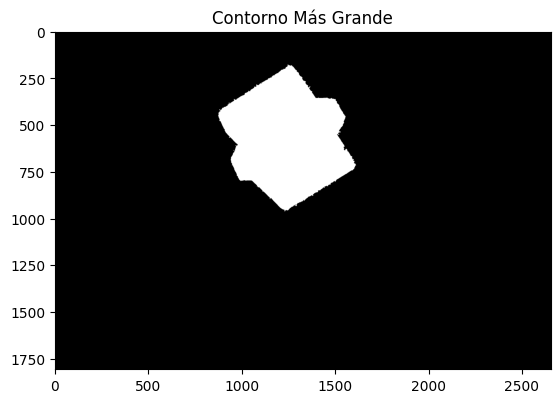

In [87]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_image(image,showImages=True):
    # Cargar la imagen

    if image is None:
        return "No se pudo cargar la imagen"
    
    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if showImages:
        plt.imshow(gray, cmap='gray')
        plt.title('Imagen en escala de grises')
        plt.show()

    # Detección de bordes con Canny
    edges = cv2.Canny(gray, 50, 50)
    if showImages:
        plt.imshow(edges, cmap='gray')
        plt.title('Detección de Bordes con Canny')
        plt.show()


    # Engrosar los bordes detectados
        # Crear un kernel de tamaño 3x3
    kernel = np.ones((3,3), np.uint8)
    
    # Aplicar la operación de apertura
    dilated_image = cv2.morphologyEx(edges, cv2.MORPH_DILATE, kernel)
    if showImages:
        plt.imshow(dilated_image, cmap='gray')
        plt.title('Dilate')
        plt.show()
    erode_image = cv2.morphologyEx(dilated_image, cv2.MORPH_ERODE, (2,2))
    if showImages:
        plt.imshow(erode_image, cmap='gray')
        plt.title('Erode')
        plt.show()
    
    # Aplicar filtro  para eliminar el ruido
    blurred_image = cv2.medianBlur(erode_image, 5)
    if showImages:
        plt.imshow(blurred_image, cmap='gray')
        plt.title('Redduccion de ruido')
        plt.show()

        # Aplicar umbral para mantener solo los valores de gris > 200
    thesh=200
    _, thresholded_image = cv2.threshold(blurred_image, thesh, 255, cv2.THRESH_BINARY)
    
    # Mostrar la imagen umbralizada
    if showImages:
        plt.imshow(thresholded_image, cmap='gray')
        plt.title('Umbral > '+str(thesh)
        plt.show()

    # Encontrar contornos
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Dibujar y rellenar contornos
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    if showImages:

        plt.imshow(mask, cmap='gray')
        plt.title('Máscara con Contornos Rellenos')
        plt.show()

    # Encontrar el contorno más grande basado en el área
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Crear una imagen para mostrar el contorno más grande
    largest_contour_image = np.zeros_like(gray)
    cv2.drawContours(largest_contour_image, [largest_contour], -1, (255), thickness=cv2.FILLED)
    
    # Mostrar el contorno más grande
    if showImages:
        plt.imshow(largest_contour_image, cmap='gray')
        plt.title('Contorno Más Grande')
        plt.show()

    return largest_contour_image
    

# Llamada a la función
binary_image = process_image(result_image,showImages=True)


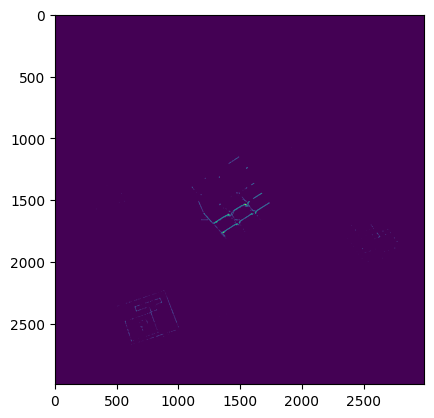

In [19]:
def enhanced_laplance(imagen):
    laplacian = cv.Laplacian(imagen, cv.CV_64F)

    # Convertir a uint8 desde float
    laplacian = np.uint8(np.absolute(laplacian))
    imagen=imagen-laplacian
    return imagen

In [20]:
def get_silhouette_from_image(input_image,has_holes=False):
    
    #1ºTransformar imagen a niveles de grises:
    original = cv.imread(cv.samples.findFile(input_image))


    gris = cv.cvtColor(original, cv.COLOR_BGR2GRAY)
    
    #2ºEliminar ruido de la imagen gris:
    median = cv.medianBlur(gris,11)
    
    #3ºObtener imagen umbralizada:
    _, imagen_binaria = cv.threshold(median, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    plt.imshow(imagen_binaria,cmap="gray")
    imagen_binaria = imagen_binaria.astype(np.uint8)
    plt.title('1º IMAGEN BINARIZADA')
    plt.figure()
    th2=median
    if(has_holes):
        th2 = cv.adaptiveThreshold(median,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
        cv.THRESH_BINARY,11,2)
        plt.imshow(th2,cmap="gray")
        plt.title('2º IMAGEN UMBRALIZADA PARA CONTORNOS')
        plt.figure()
        
    
    plt.imshow(median,cmap="gray")
    plt.title('3º Suavizado')
    plt.figure()

    #4º Capturar contornos
    canny = cv.Canny(th2, 0, 150)
    
    if(has_holes):
        retr_method=cv.RETR_CCOMP
    else:
        retr_method=cv.RETR_EXTERNAL
    
    (contornos,jerarquias) = cv.findContours(canny.copy(), retr_method, cv.CHAIN_APPROX_NONE)
    black_background = np.zeros_like(original)
    cv.drawContours(black_background, contornos, -1, (255,255,255), -1)
    plt.imshow(black_background,cmap="gray")
    plt.title('4ºContorno capturado')
    plt.figure()
    
    #5º Aplicar Operación morfológica de erosión y cierre para unir y rellenar contornos
    kernel =cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
    erosionada = cv.morphologyEx(canny, cv.MORPH_TOPHAT, kernel)
    kernel1 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10))
    imagen_cerrada = cv.morphologyEx(erosionada, cv.MORPH_CLOSE, kernel1)
    (contornos,_) = cv.findContours(imagen_cerrada.copy(), retr_method, cv.CHAIN_APPROX_NONE)
    black_background = np.zeros_like(original,dtype=np.uint8)
    cv.drawContours(black_background, contornos, -1,(255,255,255), -1)
    plt.imshow(black_background)
    plt.title('5ºContorno cerrado y rellenado')
    plt.figure()
    
    
    #6º Extra: Operación OR entre contorno rellenado y NOT(imagen binarizada)
    black_background = black_background.astype(np.uint8)
    black_background = cv.cvtColor(black_background, cv.COLOR_BGR2GRAY)
    notbinary=cv.bitwise_not(imagen_binaria)
    notbinary=notbinary.astype(np.uint8)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(20,20))
    clean = cv.morphologyEx(notbinary, cv.MORPH_CLOSE, kernel)
    if notbinary.shape == black_background.shape:
        orr = cv.bitwise_or(clean, black_background)
        plt.imshow(orr, cmap="gray")
        plt.title('6º Operación OR de Contorno e Imagen binarizada')
        plt.figure()
    else:
        print("Error: Las dimensiones de las imágenes no coinciden.")

    return orr

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

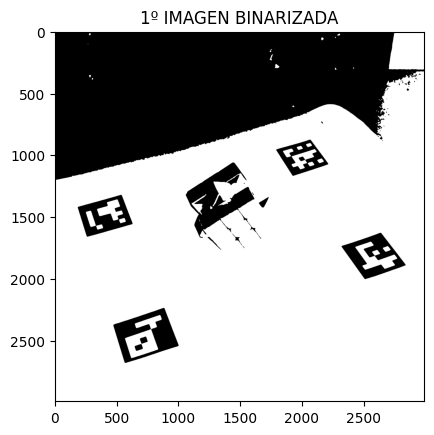

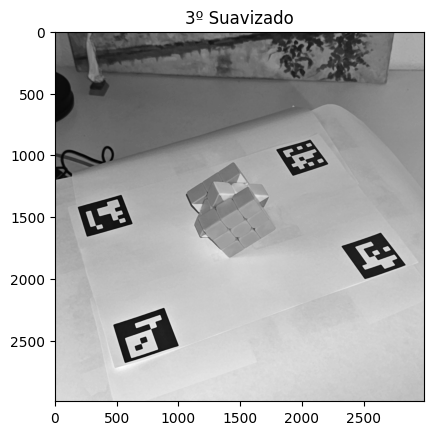

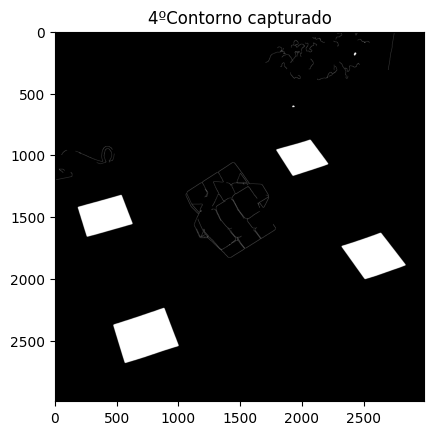

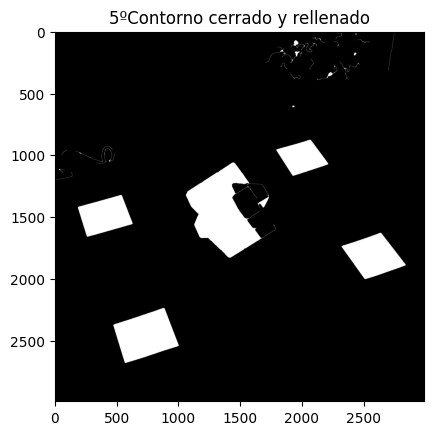

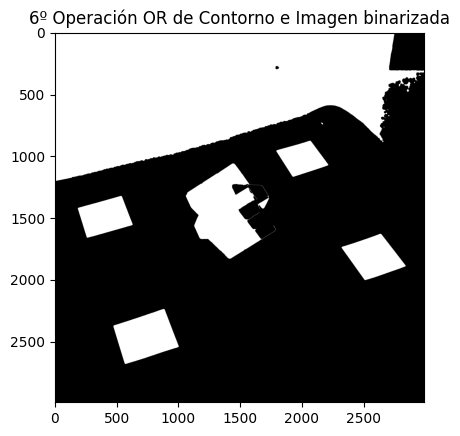

<Figure size 640x480 with 0 Axes>

In [21]:
get_silhouette_from_image(image_name)

# Visual Hull by egrigokhan

In [27]:
# Define a voxel grid which has the 3D locations of each voxel which can then be projected onto each image
def InitializeVoxels(xlim, ylim, zlim, voxel_size):
  voxels_number = [1, 1, 1]
  voxels_number[0] = np.abs(xlim[1]-xlim[0]) / voxel_size[0]
  voxels_number[1] = np.abs(ylim[1]-ylim[0]) / voxel_size[1]
  voxels_number[2] = np.abs(zlim[1]-zlim[0]) / voxel_size[2]
  voxels_number_act = np.array(voxels_number).astype(int) + 1
  total_number = np.prod(voxels_number_act)

  voxel = np.ones((int(total_number), 4))

  sx = xlim[0]
  ex = xlim[1]
  sy = ylim[0]
  ey = ylim[1]
  sz = zlim[0]
  ez = zlim[1]

  if(ex > sx):
    x_step = voxel_size[0];
  else:
    x_step = -voxel_size[0];

  if(ey > sy):
    y_step = voxel_size[1];
  else:
    y_step = -voxel_size[1];

  if(sz > ez):
    z_step = voxel_size[2];
  else:
    z_step = -voxel_size[2];

  voxel3Dx, voxel3Dy, voxel3Dz = np.meshgrid(np.linspace(sx, ex, voxels_number_act[0]), 
                                             np.linspace(sy, ey, voxels_number_act[1]),
                                             np.linspace(ez, sz, voxels_number_act[2]))
  
  l = 0;
  for z in np.linspace(ez, sz, voxels_number_act[2]):
    for x in np.linspace(sx, ex, voxels_number_act[0]):
      for y in np.linspace(sy, ey, voxels_number_act[1]):
        voxel[l] = [x, y, z, 1] 
        l=l+1

  return voxel, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number

In [28]:
voxel_size = [0.001, 0.001, 0.001] # size of each voxel

# The dimension limits
xlim = [-0.07, 0.02]
ylim = [-0.02, 0.07]
zlim = [-0.07, 0.02]

voxels, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number = InitializeVoxels(xlim, ylim, zlim, voxel_size);

In [29]:
object_points3D = np.copy(voxels).T
voxels[:, 3] = 0 # making the fourth variable of each voxel 0

proj = []

for i in range(N):

  # CAMERA PARAMETERS
  M_ = M[i]

  # PROJECTION TO THE IMAGE PLANE
  points2D = np.matmul(M_, object_points3D)
  points2D = np.floor(points2D / points2D[2, :]).astype(np.int32)
  points2D[np.where(points2D < 0)] = 0; # check for negative image coordinates

  img_size = (silhouettes).shape
  ind1 = np.where(points2D[1, :] >= img_size[0]) # check for out-of-bounds (width) coordinate
  points2D[:, ind1] = 0
  ind1 = np.where(points2D[0, :] >= img_size[1]) # check for out-of-bounds (height) coordinate
  points2D[:, ind1] = 0

  # ACCUMULATE THE VALUE OF EACH VOXEL IN THE CURRENT IMAGE
  voxels[:, 3] += silhouettes[:, :, i].T[points2D.T[:, 0], points2D.T[:, 1]]

  proj.append(points2D)

NameError: name 'N' is not defined

In [ ]:
def ConvertVoxelList2Voxel3D(voxels_number, voxel_size, voxel):
  sx = -(voxels_number[0] / 2) * voxel_size[0]
  ex = voxels_number[0] / 2 * voxel_size[0]

  sy = -(voxels_number[1] / 2) * voxel_size[1]
  ey = voxels_number[1] / 2 * voxel_size[1]
  sz = 0;
  ez = voxels_number[2] * voxel_size[2]
  voxels_number = np.array(voxels_number).astype(np.int32)
  voxel3D = np.zeros((voxels_number[1] + 1, voxels_number[0] + 1, voxels_number[2] + 1));

  l = 0
  z1 = 0
  for z in np.arange(ez, sz, -voxel_size[2]):
      x1 = 0
      for x in np.arange(sx, ex, voxel_size[0]):
          y1 = 0
          for y in np.arange(sy, ey, voxel_size[1]):
              voxel3D[y1, x1, z1] = voxel[l, 3]
              l = l + 1
              y1 = y1 + 1
          x1 = x1 + 1
      z1 = z1 + 1

  return voxel3D

In [ ]:
error_amount = 5
maxv = np.max(voxels[:, 3])
iso_value = maxv-np.round(((maxv)/100)*error_amount)-0.5
print('max number of votes:' + str(maxv))
print('threshold for marching cube:' + str(iso_value))

voxel3D = ConvertVoxelList2Voxel3D(np.array(voxels_number), voxel_size, voxels)

In [ ]:
!pip install --upgrade PyMCubes
!pip install pycollada

In [ ]:
import numpy as np
import mcubes

# Extract the 0-isosurface
vertices, triangles = mcubes.marching_cubes(voxel3D, iso_value)

# Export the result to sphere.dae
mcubes.export_mesh(vertices, triangles, "cube.dae", "cube")